Pattern Type: A, Min Support: 0.1
Frequent Itemsets Transformed to Words:
['account', 'administration', 'advertising', 'america', 'american', 'blades', 'bush', 'bushs', 'campaign', 'candidate', 'candidates', 'challenge', 'challenger', 'challengers', 'challenging', 'contact', 'country', 'create', 'culture', 'dean', 'dem', 'democratic', 'democrats', 'dkosopedia', 'economy', 'edwards', 'election', 'elections', 'electoral', 'end', 'experience', 'fact', 'general', 'george', 'gop', 'government', 'governor', 'ground', 'hard', 'homepage', 'house', 'important', 'including', 'iraq', 'issue', 'ive', 'john', 'kerry', 'kerrys', 'kossacks', 'labor', 'latest', 'lead', 'long', 'man', 'media', 'meteor', 'midday', 'military', 'million', 'money', 'national', 'needed', 'news', 'nov', 'november', 'numbers', 'oct', 'party', 'people', 'percent', 'political', 'poll', 'polling', 'polls', 'president', 'presidential', 'press', 'primary', 'public', 'put', 'question', 'race', 'races', 'real', 'recommended', 'repor

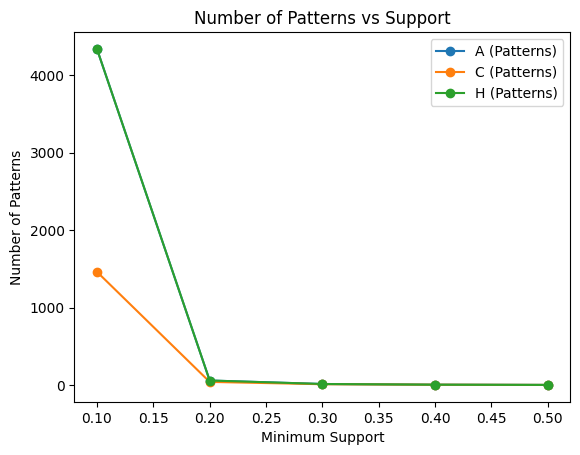

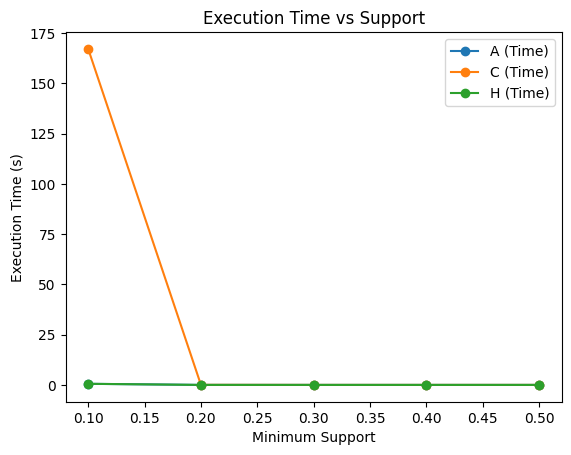

In [10]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
import time
import matplotlib.pyplot as plt

# 讀取文件
def load_data(docword_path, vocab_path):
    with open(docword_path, 'r') as f:
        lines = f.readlines()
    D, W, NNZ = map(int, lines[:3])  # 頭部資訊
    data = [list(map(int, line.split())) for line in lines[3:]]
    transactions = pd.DataFrame(data, columns=['docID', 'wordID', 'count'])

    with open(vocab_path, 'r') as f:
        vocab = [line.strip() for line in f.readlines()]

    return transactions, vocab

# 建立交易資料
def create_transactions(transactions, vocab):
    pivot_data = transactions.pivot(index='docID', columns='wordID', values='count').fillna(0)
    pivot_data = (pivot_data > 0)  # 二值化
    return pivot_data

# 模式挖掘（A: All frequent, C: Closed frequent, H: Hyperclique）
def mine_patterns(data, min_support, pattern_type='A'):
    start_time = time.time()
    frequent_itemsets = apriori(data, min_support=min_support, use_colnames=True)
    if pattern_type == 'C':  # Closed frequent
        frequent_itemsets['is_closed'] = frequent_itemsets.apply(
            lambda row: all(
                not set(row['itemsets']).issubset(set(other['itemsets']))
                for _, other in frequent_itemsets.iterrows()
                if len(row['itemsets']) < len(other['itemsets'])
            ), axis=1
        )
        frequent_itemsets = frequent_itemsets[frequent_itemsets['is_closed']]
    elif pattern_type == 'H':  # Hyperclique
        frequent_itemsets = frequent_itemsets[frequent_itemsets['support'] >= min_support]  # 超簇模式需要更嚴格的支持度
    exec_time = time.time() - start_time
    return frequent_itemsets, exec_time

# 結果轉換為原始單詞
def transform_to_words(itemsets, vocab):
    return [", ".join([vocab[item - 1] for item in items]) for items in itemsets]

# 儲存結果到 CSV 檔案
def save_results_to_csv(results, filename):
    records = []
    for support, patterns in results.items():
        for pattern_type, data in patterns.items():
            itemsets = data['itemsets']
            exec_time = data['exec_time']
            num_patterns = len(itemsets)
            for itemset in itemsets:
                records.append({
                    "Support": support,
                    "Pattern_Type": pattern_type,
                    "Execution_Time(s)": exec_time,
                    "Num_Patterns": num_patterns,
                    "Frequent_Itemset": itemset
                })
    df = pd.DataFrame(records)
    df.to_csv(filename, index=False)

# 繪圖
def plot_results(supports, results, title, ylabel, metric_label):
    plt.figure()
    for pattern_type, values in results.items():
        plt.plot(supports, values, marker='o', label=f"{pattern_type} ({metric_label})")
    plt.title(title)
    plt.xlabel('Minimum Support')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# 主函式
def main(docword_path, vocab_path, thresholds):
    transactions, vocab = load_data(docword_path, vocab_path)
    data = create_transactions(transactions, vocab)

    results = {}  # 存儲所有結果（支持度 -> 模式類型 -> 結果數據）
    num_patterns_results = {'A': [], 'C': [], 'H': []}
    exec_times_results = {'A': [], 'C': [], 'H': []}

    for support in thresholds:
        results[support] = {}
        for pattern_type in ['A', 'C', 'H']:
            exec_times = []
            for _ in range(5):  # 執行 5 次以計算平均時間
                frequent_itemsets, exec_time = mine_patterns(data, support, pattern_type)
                exec_times.append(exec_time)
            avg_exec_time = sum(exec_times) / len(exec_times)
            transformed_itemsets = transform_to_words(frequent_itemsets['itemsets'], vocab)
            num_patterns = len(frequent_itemsets)
            
            # 儲存到結果結構中
            results[support][pattern_type] = {
                "exec_time": avg_exec_time,
                "num_patterns": num_patterns,
                "itemsets": transformed_itemsets
            }
            num_patterns_results[pattern_type].append(num_patterns)
            exec_times_results[pattern_type].append(avg_exec_time)
            print(f"Pattern Type: {pattern_type}, Min Support: {support}")
            print("Frequent Itemsets Transformed to Words:")
            print(transformed_itemsets)

    # 儲存結果到 CSV 檔案
    save_results_to_csv(results, "pattern_mining_results.csv")

    # 繪製圖表
    plot_results(thresholds, num_patterns_results, 
                 "Number of Patterns vs Support", 
                 "Number of Patterns", "Patterns")
    plot_results(thresholds, exec_times_results, 
                 "Execution Time vs Support", 
                 "Execution Time (s)", "Time")

# 設定路徑和支持度閾值
docword_path = "docword.kos.txt"
vocab_path = "vocab.kos.txt"
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

main(docword_path, vocab_path, thresholds)


Loaded 25000 reviews.
Vocabulary size: 1000


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: A, Min Support: 0.1
Frequent Itemsets Transformed to Words:
['10', 'acting', 'actors', 'actually', 'bad', 'best', 'better', 'big', 'bit', 'cast', 'character', 'characters', 'come', 'did', 'didn', 'director', 'does', 'doesn', 'don', 'end', 'fact', 'far', 'film', 'films', 'funny', 'gets', 'going', 'good', 'got', 'great', 'interesting', 'isn', 'just', 'know', 'life', 'like', 'little', 'long', 'look', 'lot', 'love', 'make', 'makes', 'making', 'man', 'movie', 'movies', 'new', 'old', 'people', 'plot', 'point', 'pretty', 'quite', 'real', 'really', 'right', 'saw', 'say', 'scene', 'scenes', 'script', 'seen', 'story', 'thing', 'things', 'think', 'thought', 'time', 'times', 've', 'want', 'watch', 'watching', 'way', 'work', 'world', 'years', 'young', 'acting, film', 'acting, good', 'just, acting', 'acting, like', 'acting, movie', 'film, bad', 'bad, good', 'just, bad', 'like, bad', 'bad, movie', 'film, best', 'movie, best', 'better, film', 'better, like', 'better, movie', 'film, chara

/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: C, Min Support: 0.1
Frequent Itemsets Transformed to Words:
['10', 'actors', 'actually', 'big', 'bit', 'cast', 'come', 'didn', 'doesn', 'fact', 'far', 'funny', 'gets', 'going', 'got', 'interesting', 'isn', 'long', 'look', 'lot', 'makes', 'making', 'new', 'old', 'point', 'pretty', 'quite', 'real', 'right', 'saw', 'script', 'things', 'thought', 'times', 'want', 'work', 'world', 'years', 'young', 'acting, film', 'acting, good', 'just, acting', 'acting, like', 'acting, movie', 'film, bad', 'bad, good', 'just, bad', 'like, bad', 'bad, movie', 'film, best', 'movie, best', 'better, film', 'better, like', 'better, movie', 'film, character', 'like, character', 'character, movie', 'film, characters', 'just, characters', 'like, characters', 'movie, characters', 'film, did', 'just, did', 'like, did', 'did, movie', 'film, director', 'does, film', 'does, like', 'does, movie', 'film, don', 'don, good', 'just, don', 'don, really', 'don, time', 'film, end', 'movie, end', 'film, films', 'f

/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: H, Min Support: 0.1
Frequent Itemsets Transformed to Words:
['10', 'acting', 'actors', 'actually', 'bad', 'best', 'better', 'big', 'bit', 'cast', 'character', 'characters', 'come', 'did', 'didn', 'director', 'does', 'doesn', 'don', 'end', 'fact', 'far', 'film', 'films', 'funny', 'gets', 'going', 'good', 'got', 'great', 'interesting', 'isn', 'just', 'know', 'life', 'like', 'little', 'long', 'look', 'lot', 'love', 'make', 'makes', 'making', 'man', 'movie', 'movies', 'new', 'old', 'people', 'plot', 'point', 'pretty', 'quite', 'real', 'really', 'right', 'saw', 'say', 'scene', 'scenes', 'script', 'seen', 'story', 'thing', 'things', 'think', 'thought', 'time', 'times', 've', 'want', 'watch', 'watching', 'way', 'work', 'world', 'years', 'young', 'acting, film', 'acting, good', 'just, acting', 'acting, like', 'acting, movie', 'film, bad', 'bad, good', 'just, bad', 'like, bad', 'bad, movie', 'film, best', 'movie, best', 'better, film', 'better, like', 'better, movie', 'film, chara

/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: A, Min Support: 0.2
Frequent Itemsets Transformed to Words:
['acting', 'bad', 'characters', 'don', 'film', 'good', 'great', 'just', 'like', 'make', 'movie', 'movies', 'people', 'plot', 'really', 'seen', 'story', 'think', 'time', 'watch', 'way', 'film, good', 'just, film', 'film, like', 'film, movie', 'film, time', 'like, good', 'movie, good', 'just, like', 'just, movie', 'like, movie', 'movie, really', 'movie, time']


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: C, Min Support: 0.2
Frequent Itemsets Transformed to Words:
['acting', 'bad', 'characters', 'don', 'great', 'make', 'movies', 'people', 'plot', 'seen', 'story', 'think', 'watch', 'way', 'film, good', 'just, film', 'film, like', 'film, movie', 'film, time', 'like, good', 'movie, good', 'just, like', 'just, movie', 'like, movie', 'movie, really', 'movie, time']


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Pattern Type: H, Min Support: 0.2
Frequent Itemsets Transformed to Words:
['acting', 'bad', 'characters', 'don', 'film', 'good', 'great', 'just', 'like', 'make', 'movie', 'movies', 'people', 'plot', 'really', 'seen', 'story', 'think', 'time', 'watch', 'way', 'film, good', 'just, film', 'film, like', 'film, movie', 'film, time', 'like, good', 'movie, good', 'just, like', 'just, movie', 'like, movie', 'movie, really', 'movie, time']


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: A, Min Support: 0.3
Frequent Itemsets Transformed to Words:
['film', 'good', 'just', 'like', 'movie', 'really', 'story', 'time', 'film, movie', 'like, movie']


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: C, Min Support: 0.3
Frequent Itemsets Transformed to Words:
['good', 'just', 'really', 'story', 'time', 'film, movie', 'like, movie']


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: H, Min Support: 0.3
Frequent Itemsets Transformed to Words:
['film', 'good', 'just', 'like', 'movie', 'really', 'story', 'time', 'film, movie', 'like, movie']


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: A, Min Support: 0.4
Frequent Itemsets Transformed to Words:
['film', 'just', 'like', 'movie']


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: C, Min Support: 0.4
Frequent Itemsets Transformed to Words:
['film', 'just', 'like', 'movie']


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: H, Min Support: 0.4
Frequent Itemsets Transformed to Words:
['film', 'just', 'like', 'movie']


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: A, Min Support: 0.5
Frequent Itemsets Transformed to Words:
['film', 'movie']


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: C, Min Support: 0.5
Frequent Itemsets Transformed to Words:
['film', 'movie']


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with n

Pattern Type: H, Min Support: 0.5
Frequent Itemsets Transformed to Words:
['film', 'movie']


/home/oreo/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


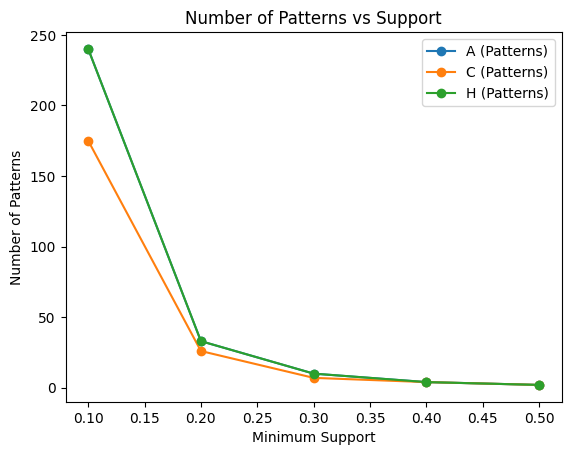

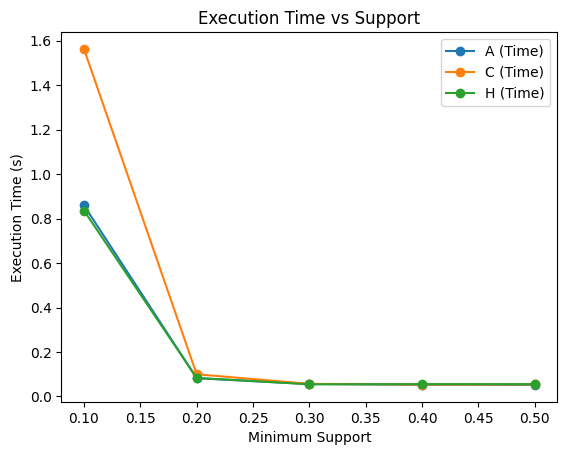

In [9]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from mlxtend.frequent_patterns import apriori
import time
import matplotlib.pyplot as plt

# 讀取 IMDb 資料
def load_reviews(data_dir):
    reviews = []
    labels = []
    for label in ['pos', 'neg']:
        folder_path = os.path.join(data_dir, label)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                content = content.replace('<br />', ' ')  # 移除 HTML 標籤
                reviews.append(content)
                labels.append(label)
    return reviews, labels

# 將文本轉換為 Bag-of-Words
def preprocess_reviews(reviews, max_features=1000):
    vectorizer = CountVectorizer(max_features=max_features, stop_words='english', binary=True)
    bow_matrix = vectorizer.fit_transform(reviews)
    vocab = vectorizer.get_feature_names_out()
    bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vocab)
    return bow_df, vocab

# 模式挖掘（A: All frequent, C: Closed frequent, H: Hyperclique）
def mine_patterns(data, min_support, pattern_type='A'):
    start_time = time.time()
    frequent_itemsets = apriori(data, min_support=min_support, use_colnames=True)
    if pattern_type == 'C':  # Closed frequent
        frequent_itemsets['is_closed'] = frequent_itemsets.apply(
            lambda row: all(
                not set(row['itemsets']).issubset(set(other['itemsets']))
                for _, other in frequent_itemsets.iterrows()
                if len(row['itemsets']) < len(other['itemsets'])
            ), axis=1
        )
        frequent_itemsets = frequent_itemsets[frequent_itemsets['is_closed']]
    elif pattern_type == 'H':  # Hyperclique
        frequent_itemsets = frequent_itemsets[frequent_itemsets['support'] >= min_support]  # 超簇模式需要更嚴格的支持度
    exec_time = time.time() - start_time
    return frequent_itemsets, exec_time

# 儲存結果到 CSV 檔案
def save_results_to_csv(results, filename):
    records = []
    for support, patterns in results.items():
        for pattern_type, data in patterns.items():
            itemsets = data['itemsets']
            exec_time = data['exec_time']
            num_patterns = len(itemsets)
            for itemset in itemsets:
                records.append({
                    "Support": support,
                    "Pattern_Type": pattern_type,
                    "Execution_Time(s)": exec_time,
                    "Num_Patterns": num_patterns,
                    "Frequent_Itemset": itemset
                })
    df = pd.DataFrame(records)
    df.to_csv(filename, index=False)

# 繪製結果
def plot_results(supports, results, title, ylabel, metric_label):
    plt.figure()
    for pattern_type, values in results.items():
        plt.plot(supports, values, marker='o', label=f"{pattern_type} ({metric_label})")
    plt.title(title)
    plt.xlabel("Minimum Support")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# 主函式
def main(data_dir, thresholds):
    reviews, labels = load_reviews(data_dir)
    print(f"Loaded {len(reviews)} reviews.")

    # 預處理評論
    bow_data, vocab = preprocess_reviews(reviews)
    print(f"Vocabulary size: {len(vocab)}")

    results = {}  # 存儲所有結果（支持度 -> 模式類型 -> 結果數據）
    num_patterns_results = {'A': [], 'C': [], 'H': []}
    exec_times_results = {'A': [], 'C': [], 'H': []}

    for support in thresholds:
        results[support] = {}
        for pattern_type in ['A', 'C', 'H']:
            exec_times = []
            for _ in range(5):  # 執行 5 次以計算平均時間
                frequent_itemsets, exec_time = mine_patterns(bow_data, support, pattern_type)
                exec_times.append(exec_time)
            avg_exec_time = sum(exec_times) / len(exec_times)
            transformed_itemsets = frequent_itemsets['itemsets'].apply(
                lambda items: ", ".join(items)  # 直接處理為可讀字符串
            ).tolist()
            num_patterns = len(frequent_itemsets)

            # 儲存到結果結構中
            results[support][pattern_type] = {
                "exec_time": avg_exec_time,
                "num_patterns": num_patterns,
                "itemsets": transformed_itemsets
            }
            num_patterns_results[pattern_type].append(num_patterns)
            exec_times_results[pattern_type].append(avg_exec_time)
            print(f"Pattern Type: {pattern_type}, Min Support: {support}")
            print("Frequent Itemsets Transformed to Words:")
            print(transformed_itemsets)




    # 儲存結果到 CSV 檔案
    save_results_to_csv(results, "imdb_pattern_mining_results.csv")

    # 繪製圖表
    plot_results(thresholds, num_patterns_results, 
                 "Number of Patterns vs Support", 
                 "Number of Patterns", "Patterns")
    plot_results(thresholds, exec_times_results, 
                 "Execution Time vs Support", 
                 "Execution Time (s)", "Time")

# 設置路徑與參數
data_dir = "aclImdb/train"
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
main(data_dir, thresholds)
